# Dokumentacja

## Autorzy

<p>Konrad Opaliński</p>

<p>Wojciech Sitek</p>

## Interpretacja zadania

<p>Tematem projektu było przewidywanie korków (atrybut Slowness in traffic(%)) w Sao Paulo na podstwie danych o godzinie oraz ilości zdarzeń nadzwyczajnych tj. zepsuty pojazd, pożar, wypadek, itp.</p>

<p>Głównym zadaniem było porównanie wyników uzyskanych za pomocą regresji liniowej oraz perceptronu wielowarstwowego (MLP).</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from warnings import filterwarnings

%matplotlib inline

## Przedstawienie zbioru danych

<p>Zbiór danych zawiera 18 kolumn oraz 135 wierszy. Pierwsza kolumna zawiera zakodowaną godzinę pomiaru (*1). Kolejne 16 kolumn zawiera ilość zdarzeń danego typu, które miały miejsce o danej godzinie, a w ostatniej kolumnie znajduje się spowolnienie w ruchu (nasza kolumna wynikowa).</p>

<p>Należy ponadto zauważyć, że zbiór danych zawiera informacje o korkach w zależności od danego dnia roboczego. Niestety w tym przypadku nasz model będzie musiał być uczony na danych z innych dni w porównaniu do tych, na których będzie testowany. Zakładając jednak, że są to jedynie dane o dniach roboczych, nie powinno to znacząco wpływać na wyniki.</p>

<p>Z poniższego zestawienia danych widzimy, że w zbiorze danych nie występują pola niezawierające żadnej wartości, więc nie jest potrzebny preprocessing odrzucający niektóre wiersze lub kolumny.</p>

<p>Dzięki temu, że 17 pierwszych kolumn jest typu int64, a tylko kolumna wynikowa jest typu float64 jesteśmy w stanie skorzystać z modeli ciągłych, a nie klasyfikatorów, do których należy regresja liniowa oraz MLP z ciągłą funkcją aktywacji ReLU.</p>

<p>Z poniższych tabeli wynika, że poza godziną pomiaru, która ma równomierny rozkład, większość atrybutów ma bardzo niskie średnie wartości. Ponadtow, większość ich wartości równa to 0, ponieważ duża ilość sytuacji nadzwyczajnych zdarza się bardzo rzadko. Jeden atrybut zdarza się nawet tylko w jednym przypadku.</p>

<p>Mamy do czynienia ze zbiorem danych o bardzo ograniczonej wielkości, więc sieci, na których będziemy je trenować muszą być adekwatnie małe, a nasze oczekiwania co do wyników uczenia maszynowego - ograniczone.</p>

(*1) Godzina 1 w rzeczywistości oznacza 7:00. Każda następna cyfra to pół godziny do przodu, np. 4 - 8:30. Zbiór zawiera dane do godziny 20:00 (27).

In [2]:
# Wczytaj zbiór danych
dataset = pd.read_csv("dataset.csv", sep=';', decimal=',')
dataset.describe()

,Hour (Coded),Immobilized bus,Broken Truck,Vehicle excess,Accident victim,Running over,Fire vehicles,Occurrence involving freight,Incident involving dangerous freight,Lack of electricity,Fire,Point of flooding,Manifestations,Defect in the network of trolleybuses,Tree on the road,Semaphore off,Intermittent Semaphore,Slowness in traffic (%)
count,135.00000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,14.00000,0.340741,0.874074,0.029630,0.422222,0.118519,0.007407,0.007407,0.007407,0.118519,0.007407,0.118519,0.051852,0.229630,0.044444,0.125926,0.014815,10.051852
std,7.81789,0.659749,1.102437,0.170195,0.696116,0.346665,0.086066,0.086066,0.086066,0.504485,0.086066,0.712907,0.222554,0.818998,0.206848,0.464077,0.121261,4.363243
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.400000
25%,7.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000
50%,14.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
75%,21.00000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.850000
max,27.00000,4.000000,5.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,7.000000,1.000000,8.000000,1.000000,4.000000,1.000000,23.400000


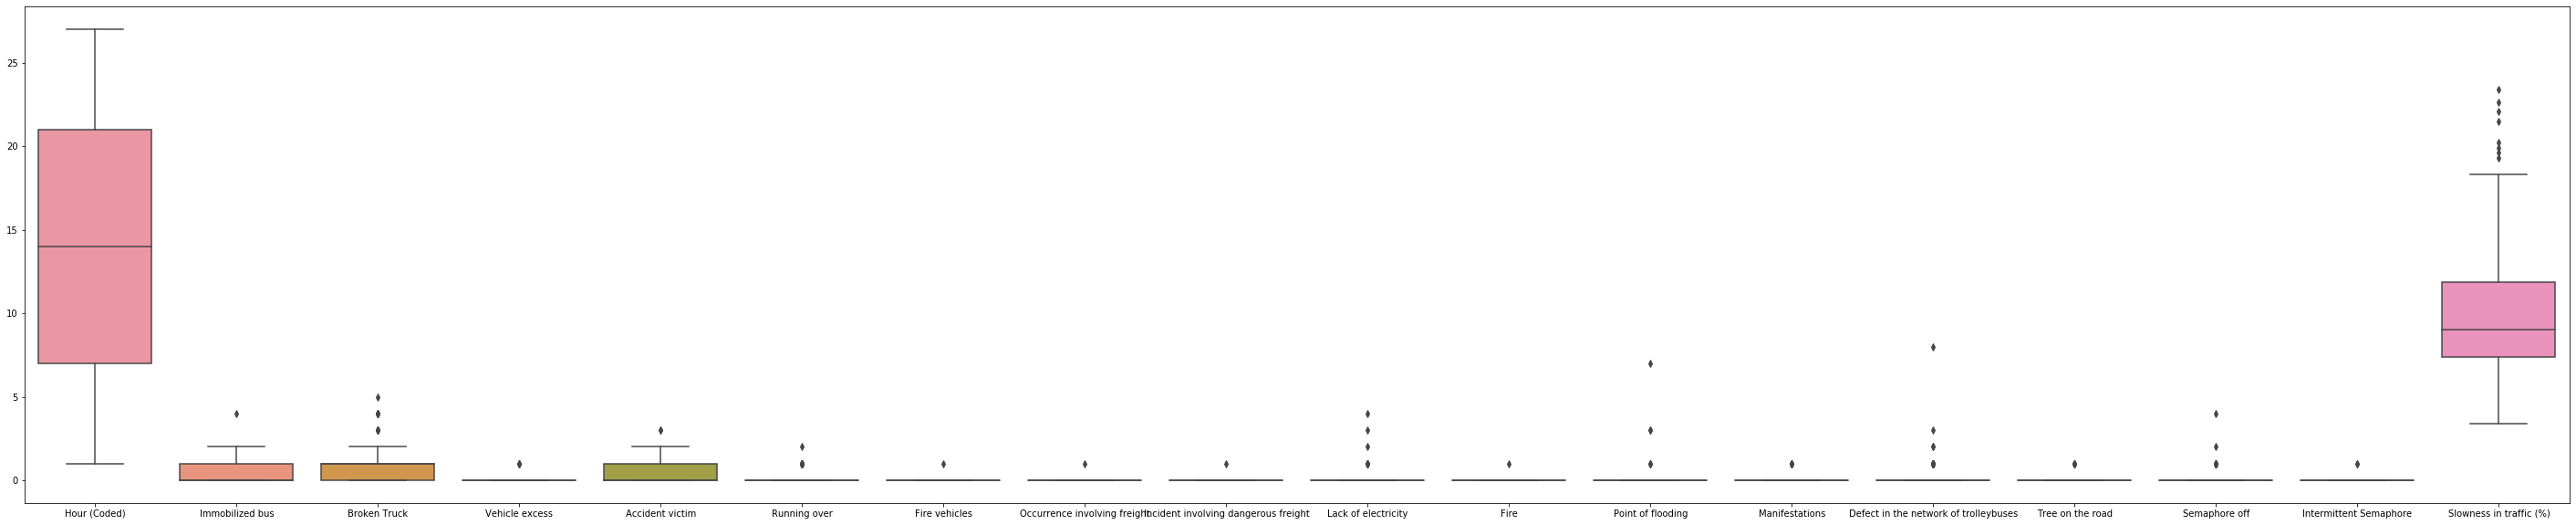

In [3]:
plt.figure(figsize=(50,10))
sbn.boxplot(data = dataset.iloc[:,:])

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 18 columns):
Hour (Coded)                             135 non-null int64
Immobilized bus                          135 non-null int64
Broken Truck                             135 non-null int64
Vehicle excess                           135 non-null int64
Accident victim                          135 non-null int64
Running over                             135 non-null int64
Fire vehicles                            135 non-null int64
Occurrence involving freight             135 non-null int64
Incident involving dangerous freight     135 non-null int64
Lack of electricity                      135 non-null int64
Fire                                     135 non-null int64
Point of flooding                        135 non-null int64
Manifestations                           135 non-null int64
Defect in the network of trolleybuses    135 non-null int64
Tree on the road                         135 non-null i

## Przygotowanie zbioru

<p>Zbiór danych zawiera informacje o korkach w zależności od dni roboczych. W naszym przypadku będziemy uczyć nasz model na zbiorze od poniedziałku do czwartku, a testować dla piątku (dzielimy zbiór 80-20 [%]).</p>

<p>Dodatkowo skalujemy dane liczbowe aby te o dużych wartościach nie zostały uznane za bardziej znaczące dla modelu.</p>

<p>Losowość została wyeliminowana przez dodanie we wszystkich funkcjach argumentu random_state o wartości 0, co pozwala na dokładne odtworzenie wyników.</p>

In [5]:
# Podział na dane wejściowe oraz wyjściowe
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [6]:
# Podział na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle=False)

In [7]:
# Dane wejściowe zbioru treningowego przed skalowaniem
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,14.000000,0.333333,0.851852,0.009259,0.379630,0.101852,0.009259,0.009259,0.009259,0.138889,0.009259,0.148148,0.055556,0.129630,0.046296,0.111111,0.018519
std,7.825193,0.655673,1.109136,0.096225,0.693327,0.333204,0.096225,0.096225,0.096225,0.554646,0.096225,0.795017,0.230129,0.434335,0.211106,0.480135,0.135445
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,14.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,27.000000,4.000000,5.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,7.000000,1.000000,3.000000,1.000000,4.000000,1.000000


In [8]:
# Dane wyjściowe zbioru treningowego przed skalowaniem
pd.DataFrame(y_train).describe()

,0
count,108.000000
mean,9.760185
std,4.424062
min,3.400000
25%,6.875000
50%,8.350000
75%,11.250000
max,23.400000


In [9]:
# Skalowanie danych liczbowych aby dane o dużych wartościach nie zostały uznane za bardziej znaczące dla modelu
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
# Dane wejściowe zbioru treningowego po skalowaniu
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,108.000000,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02,1.080000e+02
mean,-4.111937e-18,1.027984e-17,-2.672759e-17,-2.081668e-17,-5.345518e-17,0.000000,-4.882925e-18,-2.312965e-18,-2.312965e-18,-8.223874e-18,-2.055969e-17,3.289550e-17,-2.415763e-17,-5.756712e-17,2.826957e-17,8.223874e-18,-4.625929e-18
std,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00,1.004662e+00
min,-1.669046e+00,-5.107539e-01,-7.716123e-01,-9.667365e-02,-5.501002e-01,-0.307100,-9.667365e-02,-9.667365e-02,-9.667365e-02,-2.515773e-01,-9.667365e-02,-1.872146e-01,-2.425356e-01,-2.998471e-01,-2.203263e-01,-2.324953e-01,-1.373606e-01
25%,-8.987170e-01,-5.107539e-01,-7.716123e-01,-9.667365e-02,-5.501002e-01,-0.307100,-9.667365e-02,-9.667365e-02,-9.667365e-02,-2.515773e-01,-9.667365e-02,-1.872146e-01,-2.425356e-01,-2.998471e-01,-2.203263e-01,-2.324953e-01,-1.373606e-01
50%,0.000000e+00,-5.107539e-01,1.341934e-01,-9.667365e-02,-5.501002e-01,-0.307100,-9.667365e-02,-9.667365e-02,-9.667365e-02,-2.515773e-01,-9.667365e-02,-1.872146e-01,-2.425356e-01,-2.998471e-01,-2.203263e-01,-2.324953e-01,-1.373606e-01
75%,8.987170e-01,1.021508e+00,1.341934e-01,-9.667365e-02,8.989443e-01,-0.307100,-9.667365e-02,-9.667365e-02,-9.667365e-02,-2.515773e-01,-9.667365e-02,-1.872146e-01,-2.425356e-01,-2.998471e-01,-2.203263e-01,-2.324953e-01,-1.373606e-01
max,1.669046e+00,5.618293e+00,3.757416e+00,1.034408e+01,3.797033e+00,5.723221,1.034408e+01,1.034408e+01,1.034408e+01,6.993849e+00,1.034408e+01,8.658673e+00,4.123106e+00,6.639471e+00,4.538722e+00,8.137335e+00,7.280110e+00


In [11]:
# Dane wyjściowe zbioru treningowego po skalowaniu
pd.DataFrame(y_train).describe()

,0
count,108.000000
mean,9.760185
std,4.424062
min,3.400000
25%,6.875000
50%,8.350000
75%,11.250000
max,23.400000


## Liniowa regresja

<p>Poniżej zostały pokazane wyniki regresji liniowej.</p>

<p>Udało nam się uzyskać wynik 0.18 (optymalny wynik powinien być jak najbliższy 1), co nie jest zbyt dobrym wynikiem, ale można się było tego spodziewać po ilości danych.</p>

<p>Niżej zostały porównane wartości spowolnienia ruchu aktualne z przewidywanymi.</p>

<p>Następnie obliczyliśmy średni błąd kwadratowy, który wyniósł 12.48</p>

In [12]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
print("Uzyskany wynik: " + str(model.score(X_test, y_test)))

Uzyskany wynik: 0.18017242873993944


In [13]:
y_pred = model.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head(27)

,Actual,Predicted
0,3.4,-2.260941
1,5.0,4.655678
2,5.5,5.790659
3,6.4,5.091365
4,8.2,3.552002
5,9.0,4.476158
6,10.1,6.731312
7,10.3,6.642091
8,10.9,7.194735
9,12.3,7.974954


In [14]:
print("Średni błąd kwadratowy: " + str(metrics.mean_squared_error(y_test, y_pred)))

Średni błąd kwadratowy: 12.47658356705338


## MLP

<p>Przyjęte parametry sieci:</p>
<ul>
    <li>warstwy perceptronu wielowarstwowego: 10, 15, 5</li>
    <li>krok algorytmu: 1e-3</li>
    <li>funkcja aktywacji: ReLU</li>
    <li>solver: sgd</li>
</ul>
        
<p>Poniżej zostały pokazane wyniki perceptronu wielowarstwowego.</p>

<p>Udało nam się uzyskać wynik 0.34 (optymalny wynik powinien być jak najbliższy 1), co nie jest zbyt dobrym wynikiem, ale można się było tego spodziewać po ilości danych.</p>

<p>Niżej zostały porównane wartości spowolnienia ruchu aktualne z przewidywanymi.</p>

<p>Następnie obliczyliśmy średni błąd kwadratowy, który wyniósł 10.12</p>

In [15]:
filterwarnings('ignore')

mlp = MLPRegressor(hidden_layer_sizes=(10,15,5),alpha=1e-3,activation='relu',solver='sgd',random_state=0)
mlp.fit(X_train, y_train)
print("Uzyskany wynik: " + str(mlp.score(X_test, y_test)))

Uzyskany wynik: 0.3350739323002344


In [16]:
mlp_y_pred = mlp.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': mlp_y_pred.flatten()})
df.head(27)

,Actual,Predicted
0,3.4,5.600475
1,5.0,6.893732
2,5.5,6.929808
3,6.4,6.989733
4,8.2,7.904382
5,9.0,6.187252
6,10.1,7.889125
7,10.3,7.236168
8,10.9,7.201998
9,12.3,7.034352


In [17]:
print("Średni błąd kwadratowy: " + str(metrics.mean_squared_error(y_test, mlp_y_pred)))

Średni błąd kwadratowy: 10.119207916876356


## Wnioski

<p>Uzyskane wyniki średniego błędu kwadratowego oraz parametru score wyraźnie ukazują, że mamy do czynienia z bardzo małym zbiorem danych, co powoduje underfitting danych i wyniki predykcji odbiegające od rzeczywistości. Dla danego zbioru danych udało nam się osiągnąć lepszy rezultat dla sieci MLP.</p>

<p>Po spojrzeniu jednak na tabele zależności między wartościami przewidzianymi a rzeczywistymi, można dojść do wniosku, że modele odwzorowały ogólny trend danych w zależności od danych parametrów.</p>

<p>Pierwsze dwa wykresy ukazują spowolnienie ruchu w zależności od godziny. Widać, że wyniki pokrywają się, co dowodzi dostosowaniu modelu do danych.</p>

<p>Ostatni wykres dowodzi, że regresja liniowa i MLP zachowują się bardzo podobnie dla naszego zbioru danych. Jest to bardzo logiczna zależność z racji że MLP jest po prostu bardziej rozbudowanym modelem regresji liniowej.</p>

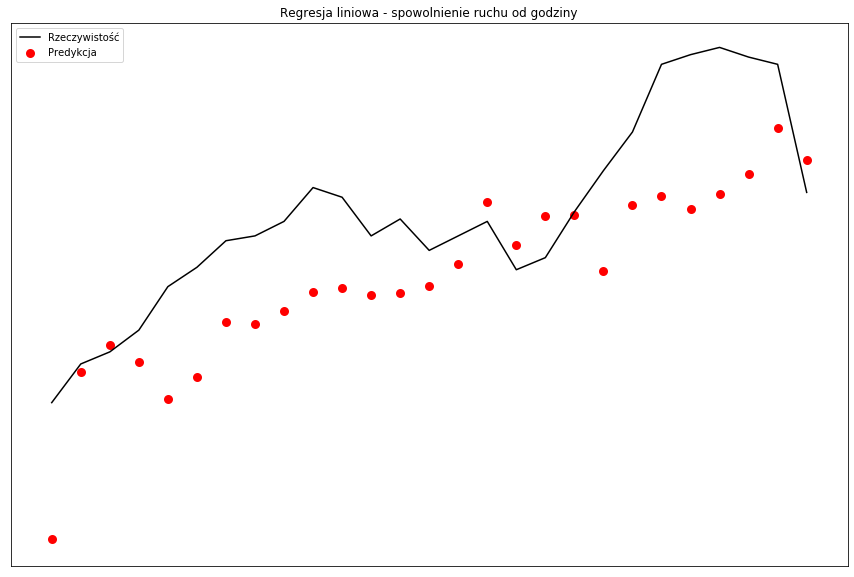

In [18]:
plt.figure(figsize=(15,10))
plt.title("Regresja liniowa - spowolnienie ruchu od godziny")
plt.plot(pd.DataFrame(X_test).iloc[:,:1], y_test,  color='black', label='Rzeczywistość')
plt.scatter(pd.DataFrame(X_test).iloc[:,:1], y_pred, color='red', linewidth=3, label='Predykcja')
plt.legend()
plt.xticks(())
plt.yticks(())
plt.show()

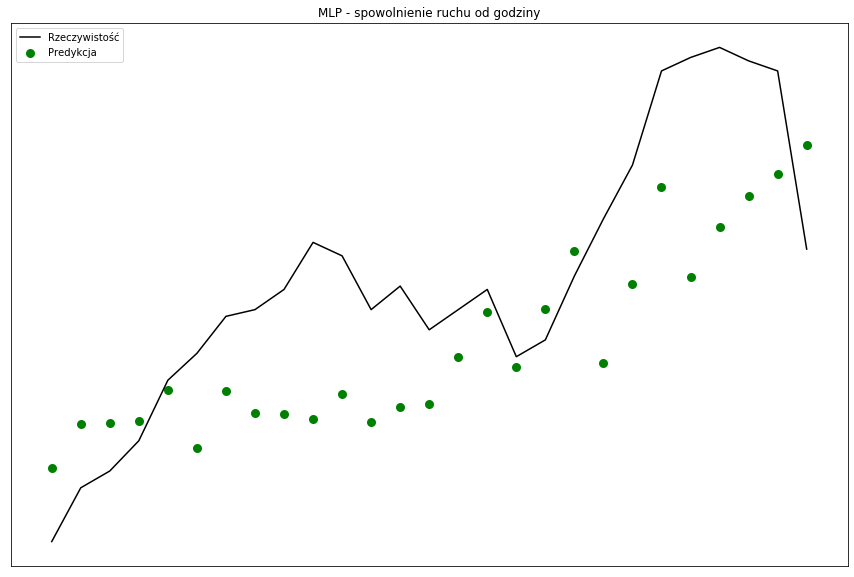

In [19]:
plt.figure(figsize=(15,10))
plt.title("MLP - spowolnienie ruchu od godziny")
plt.plot(pd.DataFrame(X_test).iloc[:,:1], y_test,  color='black', label='Rzeczywistość')
plt.scatter(pd.DataFrame(X_test).iloc[:,:1], mlp_y_pred, color='green', linewidth=3, label='Predykcja')
plt.legend()
plt.xticks(())
plt.yticks(())

plt.show()

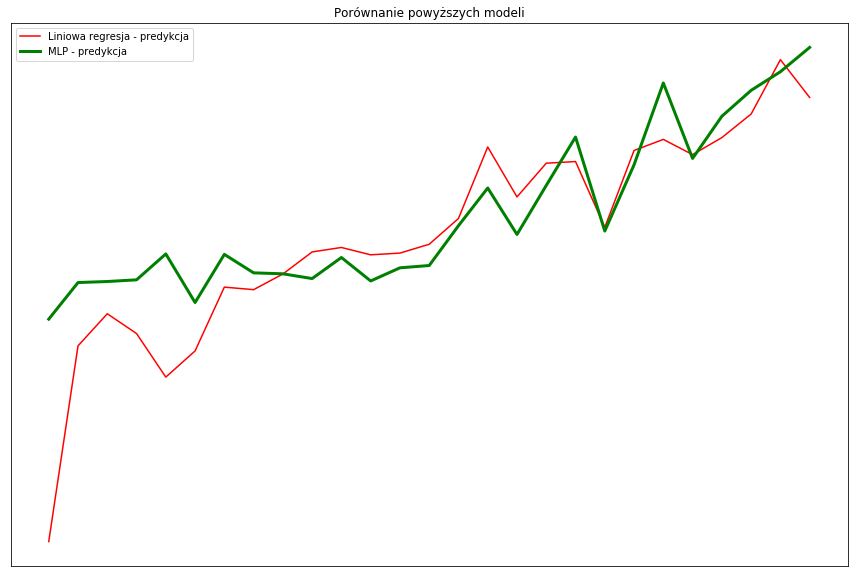

In [20]:
plt.figure(figsize=(15,10))
plt.title("Porównanie powyższych modeli")
plt.plot(pd.DataFrame(X_test).iloc[:,0], y_pred,  color='red', label='Liniowa regresja - predykcja')
plt.plot(pd.DataFrame(X_test).iloc[:,0], mlp_y_pred, color='green', linewidth=3, label='MLP - predykcja')
plt.legend()
plt.xticks(())
plt.yticks(())

plt.show()